# Colon Cancer Data

## All packages, hyperparameter evaluation functions

In [121]:
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import time
from scipy.stats import randint, uniform
from sklearn.utils.fixes import loguniform

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import missingno as msno
import pandas_profiling
from sklearn.metrics import roc_auc_score
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from hyperopt.pyll.base import scope
import pyspark

import xgboost
import shap
shap.initjs()
import numpy as np
import pandas as pd
from random import sample 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as pl

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

# Some constants

SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'

def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

#-----------------------XGBoost--------------------------#

def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV 
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                              verbose_eval=250)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)

        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
        
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # XGB param ranges obtained from Barnwal A, Cho H, Hocking T (2020). Survival regression with accelerated failure time model in XGBoost: 
    # https://arxiv.org/pdf/2006.04920.pdf
    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.001), np.log(1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,10,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.001), np.log(10)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.001), np.log(10)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.001), np.log(10)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
    return best

## Set Directory to Save Files (Assumed that Files needed for reading are in current working directory)

In [2]:
# Set working directory to save all figures (create directory beforehand)
save_to = save_to = os.getcwd() + '/'

# Colon Cancer

## Prep Datasets 

### Normalized Data

In [127]:
All_ccd = pd.read_csv("XGB_COLON_normalized.csv")
X_ccd_id = All_ccd['id']
X_ccd = All_ccd.drop(columns = ['id','SURV_DAY_XGB'])
y_ccd = All_ccd['SURV_DAY_XGB']
y_ccd.head()

0    1521
1   -3087
2     963
3     293
4     659
Name: SURV_DAY_XGB, dtype: int64

In [4]:
print(X_ccd.shape)
X_ccd.head()

(929, 10)


,rx,sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg
0,2,1,0.373134,0,0,0,0.151515,2.0,3,0
1,2,1,0.671642,0,0,0,0.030303,2.0,3,0
2,0,0,0.791045,0,0,1,0.212121,2.0,2,0
3,2,0,0.716418,1,0,0,0.181818,2.0,3,1
4,0,1,0.761194,0,0,0,0.666667,2.0,3,1


In [5]:
print(y_ccd.shape)
y_ccd.head()

(929,)


0    1521
1   -3087
2     963
3     293
4     659
Name: SURV_DAY_XGB, dtype: int64

## Hyperparm tuning, 100 evaluation rounds to find best hyperparameters to run our XGB Model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_ccd, y_ccd, test_size=0.2, random_state=20)
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

---- Running XGBoost ----
Training with params:                                  
{'eta': 0.010680013908083026, 'max_depth': 5, 'min_child_weight': 6.924137909167513, 'objective': 'survival:cox', 'reg_alpha': 0.41697748245050276, 'reg_lambda': 0.4807442983050232, 'subsample': 0.9140121115892672}
[0]	eval-cox-nloglik:4.68368	train-cox-nloglik:6.01103 

[250]	eval-cox-nloglik:4.47736	train-cox-nloglik:5.63152

[500]	eval-cox-nloglik:4.51240	train-cox-nloglik:5.51596

[750]	eval-cox-nloglik:4.56908	train-cox-nloglik:5.42744

[999]	eval-cox-nloglik:4.62774	train-cox-nloglik:5.35847

[0]	eval-cox-nloglik:4.66142	train-cox-nloglik:6.01610 

[250]	eval-cox-nloglik:4.62212	train-cox-nloglik:5.60416

[500]	eval-cox-nloglik:4.67417	train-cox-nloglik:5.49439

[750]	eval-cox-nloglik:4.71747	train-cox-nloglik:5.41497

[999]	eval-cox-nloglik:4.74881	train-cox-nloglik:5.35302

[0]	eval-cox-nloglik:4.63748	train-cox-nloglik:6.02227 

[250]	eval-cox-nloglik:4.52761	train-cox-nloglik:5.60499

[500]	eval

[750]	eval-cox-nloglik:5.66498	train-cox-nloglik:4.43178                         

[999]	eval-cox-nloglik:6.02168	train-cox-nloglik:4.25810                         

	Score 0.6128798438809954                                                        


Training with params:                                                            
{'eta': 0.44203996144137214, 'max_depth': 8, 'min_child_weight': 1.2461113881367007, 'objective': 'survival:cox', 'reg_alpha': 0.19224956581273744, 'reg_lambda': 0.0034575523376045485, 'subsample': 0.8455403296744901}
[0]	eval-cox-nloglik:4.75721	train-cox-nloglik:5.69070                           

[250]	eval-cox-nloglik:11.21725	train-cox-nloglik:3.35718                        

[500]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                 

[750]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                 

[999]	eval-cox-nloglik:nan	train-cox-nloglik:nan                                 

[0]	eval-cox-nloglik:4.73052	train-

[250]	eval-cox-nloglik:4.58378	train-cox-nloglik:5.89362                          

[500]	eval-cox-nloglik:4.55150	train-cox-nloglik:5.79468                          

[750]	eval-cox-nloglik:4.53334	train-cox-nloglik:5.71620                          

[999]	eval-cox-nloglik:4.52339	train-cox-nloglik:5.64928                          

[0]	eval-cox-nloglik:4.65025	train-cox-nloglik:6.02601                            

[250]	eval-cox-nloglik:4.58350	train-cox-nloglik:5.89205                          

[500]	eval-cox-nloglik:4.54461	train-cox-nloglik:5.78993                          

[750]	eval-cox-nloglik:4.52092	train-cox-nloglik:5.70770                          

[999]	eval-cox-nloglik:4.50575	train-cox-nloglik:5.63839                          

[0]	eval-cox-nloglik:4.56168	train-cox-nloglik:6.04576                            

[250]	eval-cox-nloglik:4.50074	train-cox-nloglik:5.90580                          

[500]	eval-cox-nloglik:4.47056	train-cox-nloglik:5.80086                    

	Score 0.6620898828647485                                                          


Training with params:                                                              
{'eta': 0.001492694641515291, 'max_depth': 3, 'min_child_weight': 0.003104642591278601, 'objective': 'survival:cox', 'reg_alpha': 7.307440543471974, 'reg_lambda': 8.508877285360315, 'subsample': 0.9602017905433725}
[0]	eval-cox-nloglik:4.68810	train-cox-nloglik:6.01570                             

[250]	eval-cox-nloglik:4.62163	train-cox-nloglik:5.95665                           

[500]	eval-cox-nloglik:4.57440	train-cox-nloglik:5.91927                           

[750]	eval-cox-nloglik:4.53965	train-cox-nloglik:5.89127                           

[999]	eval-cox-nloglik:4.51788	train-cox-nloglik:5.86912                           

[0]	eval-cox-nloglik:4.66291	train-cox-nloglik:6.02197                             

[250]	eval-cox-nloglik:4.62779	train-cox-nloglik:5.93751                           

[500]	eval-cox-nlogl

[250]	eval-cox-nloglik:4.56412	train-cox-nloglik:5.87243                           

[500]	eval-cox-nloglik:4.53008	train-cox-nloglik:5.79057                           

[750]	eval-cox-nloglik:4.51602	train-cox-nloglik:5.73423                           

[999]	eval-cox-nloglik:4.50988	train-cox-nloglik:5.68926                           

[0]	eval-cox-nloglik:4.64996	train-cox-nloglik:6.02588                             

[250]	eval-cox-nloglik:4.53580	train-cox-nloglik:5.87238                           

[500]	eval-cox-nloglik:4.49238	train-cox-nloglik:5.78723                           

[750]	eval-cox-nloglik:4.47318	train-cox-nloglik:5.72715                           

[999]	eval-cox-nloglik:4.46581	train-cox-nloglik:5.68285                           

[0]	eval-cox-nloglik:4.56149	train-cox-nloglik:6.04547                             

[250]	eval-cox-nloglik:4.47206	train-cox-nloglik:5.88440                           

[500]	eval-cox-nloglik:4.44752	train-cox-nloglik:5.79462         

	Score 0.6574241062674175                                                          


Training with params:                                                              
{'eta': 0.023779083926969934, 'max_depth': 6, 'min_child_weight': 0.07422252104950845, 'objective': 'survival:cox', 'reg_alpha': 0.01759404600217814, 'reg_lambda': 0.36989475510289516, 'subsample': 0.7670715015391141}
[0]	eval-cox-nloglik:4.67791	train-cox-nloglik:5.98930                             

[250]	eval-cox-nloglik:4.95652	train-cox-nloglik:4.85408                           

[500]	eval-cox-nloglik:5.32045	train-cox-nloglik:4.43744                           

[750]	eval-cox-nloglik:5.71826	train-cox-nloglik:4.16778                           

[999]	eval-cox-nloglik:6.16812	train-cox-nloglik:3.96356                           

[0]	eval-cox-nloglik:4.65489	train-cox-nloglik:5.99798                             

[250]	eval-cox-nloglik:4.81577	train-cox-nloglik:4.87118                           

[500]	eval-cox-nl

[0]	eval-cox-nloglik:4.63991	train-cox-nloglik:6.02469                             

[250]	eval-cox-nloglik:4.53958	train-cox-nloglik:5.74973                           

[500]	eval-cox-nloglik:4.55202	train-cox-nloglik:5.64861                           

[750]	eval-cox-nloglik:4.58562	train-cox-nloglik:5.59222                           

[999]	eval-cox-nloglik:4.62255	train-cox-nloglik:5.53699                           

[0]	eval-cox-nloglik:4.64703	train-cox-nloglik:6.02346                             

[250]	eval-cox-nloglik:4.48276	train-cox-nloglik:5.74774                           

[500]	eval-cox-nloglik:4.48226	train-cox-nloglik:5.65705                           

[750]	eval-cox-nloglik:4.49874	train-cox-nloglik:5.60158                           

[999]	eval-cox-nloglik:4.52445	train-cox-nloglik:5.55199                           

[0]	eval-cox-nloglik:4.55905	train-cox-nloglik:6.04340                             

[250]	eval-cox-nloglik:4.45759	train-cox-nloglik:5.74264         

[999]	eval-cox-nloglik:5.90431	train-cox-nloglik:4.15702                           

	Score 0.6169436264933997                                                          


Training with params:                                                              
{'eta': 0.008827567485545194, 'max_depth': 5, 'min_child_weight': 0.7648619071443394, 'objective': 'survival:cox', 'reg_alpha': 0.7931196740826406, 'reg_lambda': 2.3520055177528296, 'subsample': 0.900425803430005}
[0]	eval-cox-nloglik:4.68534	train-cox-nloglik:6.01180                             

[250]	eval-cox-nloglik:4.51660	train-cox-nloglik:5.58136                           

[500]	eval-cox-nloglik:4.56934	train-cox-nloglik:5.42213                           

[750]	eval-cox-nloglik:4.63005	train-cox-nloglik:5.30562                           

[999]	eval-cox-nloglik:4.68651	train-cox-nloglik:5.21503                           

[0]	eval-cox-nloglik:4.66167	train-cox-nloglik:6.01746                             

[250]	eval-cox-nlogli

[999]	eval-cox-nloglik:4.60422	train-cox-nloglik:5.65073                           

[0]	eval-cox-nloglik:4.64097	train-cox-nloglik:6.02738                             

[250]	eval-cox-nloglik:4.57927	train-cox-nloglik:5.87568                           

[500]	eval-cox-nloglik:4.54744	train-cox-nloglik:5.78055                           

[750]	eval-cox-nloglik:4.52992	train-cox-nloglik:5.70883                           

[999]	eval-cox-nloglik:4.52221	train-cox-nloglik:5.65148                           

[0]	eval-cox-nloglik:4.64997	train-cox-nloglik:6.02597                             

[250]	eval-cox-nloglik:4.55132	train-cox-nloglik:5.87753                           

[500]	eval-cox-nloglik:4.50729	train-cox-nloglik:5.77865                           

[750]	eval-cox-nloglik:4.48994	train-cox-nloglik:5.70512                           

[999]	eval-cox-nloglik:4.48452	train-cox-nloglik:5.64802                           

[0]	eval-cox-nloglik:4.56156	train-cox-nloglik:6.04559           

[750]	eval-cox-nloglik:4.74014	train-cox-nloglik:5.08704                           

[999]	eval-cox-nloglik:4.84950	train-cox-nloglik:4.96227                           

	Score 0.6380637425399133                                                          


Training with params:                                                              
{'eta': 0.010717970189997079, 'max_depth': 5, 'min_child_weight': 4.207519197827309, 'objective': 'survival:cox', 'reg_alpha': 0.03572668185948537, 'reg_lambda': 0.013448049724763125, 'subsample': 0.7843754306178566}
[0]	eval-cox-nloglik:4.68222	train-cox-nloglik:6.01009                             

[250]	eval-cox-nloglik:4.49561	train-cox-nloglik:5.56211                           

[500]	eval-cox-nloglik:4.56349	train-cox-nloglik:5.41292                           

[750]	eval-cox-nloglik:4.65971	train-cox-nloglik:5.30156                           

[999]	eval-cox-nloglik:4.74665	train-cox-nloglik:5.21291                           

[0]	eval-cox-nlogl

[750]	eval-cox-nloglik:4.62997	train-cox-nloglik:5.76807                           

[999]	eval-cox-nloglik:4.63135	train-cox-nloglik:5.74602                           

[0]	eval-cox-nloglik:4.64054	train-cox-nloglik:6.02719                             

[250]	eval-cox-nloglik:4.56043	train-cox-nloglik:5.88302                           

[500]	eval-cox-nloglik:4.53405	train-cox-nloglik:5.82745                           

[750]	eval-cox-nloglik:4.52148	train-cox-nloglik:5.79509                           

[999]	eval-cox-nloglik:4.51542	train-cox-nloglik:5.77231                           

[0]	eval-cox-nloglik:4.64987	train-cox-nloglik:6.02595                             

[250]	eval-cox-nloglik:4.53285	train-cox-nloglik:5.89451                           

[500]	eval-cox-nloglik:4.49075	train-cox-nloglik:5.83832                           

[750]	eval-cox-nloglik:4.46896	train-cox-nloglik:5.80432                           

[999]	eval-cox-nloglik:4.45722	train-cox-nloglik:5.78119         

[500]	eval-cox-nloglik:4.53119	train-cox-nloglik:5.56457                           

[750]	eval-cox-nloglik:4.59896	train-cox-nloglik:5.46900                           

[999]	eval-cox-nloglik:4.66981	train-cox-nloglik:5.39560                           

	Score 0.6474590163422981                                                          


Training with params:                                                              
{'eta': 0.0026528146442170355, 'max_depth': 2, 'min_child_weight': 0.007666740573412345, 'objective': 'survival:cox', 'reg_alpha': 0.12738354068964797, 'reg_lambda': 0.4871532799978708, 'subsample': 0.8339574678160059}
[0]	eval-cox-nloglik:4.68755	train-cox-nloglik:6.01520                             

[250]	eval-cox-nloglik:4.57386	train-cox-nloglik:5.90278                           

[500]	eval-cox-nloglik:4.53750	train-cox-nloglik:5.85042                           

[750]	eval-cox-nloglik:4.53150	train-cox-nloglik:5.81514                           

[999]	eval-cox-n

[500]	eval-cox-nloglik:4.66760	train-cox-nloglik:5.27538                           

[750]	eval-cox-nloglik:4.71886	train-cox-nloglik:5.14378                           

[999]	eval-cox-nloglik:4.76346	train-cox-nloglik:5.04112                           

[0]	eval-cox-nloglik:4.63807	train-cox-nloglik:6.02194                             

[250]	eval-cox-nloglik:4.51936	train-cox-nloglik:5.45901                           

[500]	eval-cox-nloglik:4.58883	train-cox-nloglik:5.23649                           

[750]	eval-cox-nloglik:4.68066	train-cox-nloglik:5.09336                           

[999]	eval-cox-nloglik:4.76909	train-cox-nloglik:4.98930                           

[0]	eval-cox-nloglik:4.64732	train-cox-nloglik:6.02076                             

[250]	eval-cox-nloglik:4.50425	train-cox-nloglik:5.45452                           

[500]	eval-cox-nloglik:4.57761	train-cox-nloglik:5.24424                           

[750]	eval-cox-nloglik:4.64395	train-cox-nloglik:5.10736         

[250]	eval-cox-nloglik:4.47233	train-cox-nloglik:5.90814                           

[500]	eval-cox-nloglik:4.44184	train-cox-nloglik:5.83790                           

[750]	eval-cox-nloglik:4.43592	train-cox-nloglik:5.79242                           

[999]	eval-cox-nloglik:4.43999	train-cox-nloglik:5.75766                           

	Score 0.659201341862827                                                           


Training with params:                                                              
{'eta': 0.04286401969451536, 'max_depth': 6, 'min_child_weight': 0.19262263762445203, 'objective': 'survival:cox', 'reg_alpha': 2.6052054739980632, 'reg_lambda': 0.01800232639070627, 'subsample': 0.787203435008865}
[0]	eval-cox-nloglik:4.67296	train-cox-nloglik:5.98736                             

[250]	eval-cox-nloglik:4.74217	train-cox-nloglik:5.12688                           

[500]	eval-cox-nloglik:4.93086	train-cox-nloglik:4.90995                           

[750]	eval-cox-nlogl

[0]	eval-cox-nloglik:4.68263	train-cox-nloglik:6.00873                             

[250]	eval-cox-nloglik:4.53549	train-cox-nloglik:5.54081                           

[500]	eval-cox-nloglik:4.60225	train-cox-nloglik:5.38112                           

[750]	eval-cox-nloglik:4.68267	train-cox-nloglik:5.26372                           

[999]	eval-cox-nloglik:4.76490	train-cox-nloglik:5.17296                           

[0]	eval-cox-nloglik:4.65925	train-cox-nloglik:6.01303                             

[250]	eval-cox-nloglik:4.64847	train-cox-nloglik:5.52543                           

[500]	eval-cox-nloglik:4.69738	train-cox-nloglik:5.38133                           

[750]	eval-cox-nloglik:4.74961	train-cox-nloglik:5.26921                           

[999]	eval-cox-nloglik:4.79464	train-cox-nloglik:5.17575                           

[0]	eval-cox-nloglik:4.63617	train-cox-nloglik:6.02030                             

[250]	eval-cox-nloglik:4.54241	train-cox-nloglik:5.52439         

[999]	eval-cox-nloglik:4.51242	train-cox-nloglik:5.71555                           

[0]	eval-cox-nloglik:4.64706	train-cox-nloglik:6.02344                             

[250]	eval-cox-nloglik:4.46541	train-cox-nloglik:5.79616                           

[500]	eval-cox-nloglik:4.44509	train-cox-nloglik:5.75755                           

[750]	eval-cox-nloglik:4.44221	train-cox-nloglik:5.74198                           

[999]	eval-cox-nloglik:4.44054	train-cox-nloglik:5.73200                           

[0]	eval-cox-nloglik:4.55862	train-cox-nloglik:6.04212                             

[250]	eval-cox-nloglik:4.43129	train-cox-nloglik:5.79705                           

[500]	eval-cox-nloglik:4.43560	train-cox-nloglik:5.75034                           

[750]	eval-cox-nloglik:4.44102	train-cox-nloglik:5.73286                           

[999]	eval-cox-nloglik:4.44465	train-cox-nloglik:5.72089                           

	Score 0.6624166595067666                                        

In [7]:
xgb_best_hyperparams['max_depth']=round(xgb_best_hyperparams['max_depth'])
xgb_best_hyperparams['objective']="survival:cox"
print(xgb_best_hyperparams)

{'eta': 0.015162969402409519, 'max_depth': 4, 'min_child_weight': 0.015606984973734611, 'reg_alpha': 9.994278334621303, 'reg_lambda': 0.049917743190706444, 'subsample': 0.7534457229737967, 'objective': 'survival:cox'}


## KFold CV 

In [8]:
xgb_scores =[]

n_folds = 5
num_boost_round=1000
skf = KFold(n_splits=n_folds)
c = 1
#k-fold CV 
for train_index, val_index in skf.split(X_train): 
    print ("Round", c, "Start")
    start = time.time()
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        
    dtrain = xgboost.DMatrix(X_tr, label=y_tr)
    dval = xgboost.DMatrix(X_val, label=y_val)

    watchlist = [(dval, 'eval'), (dtrain, 'train')]
    xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                          evals=watchlist,
                          verbose_eval=250)

    predictions = xgb_model.predict(dval,
                                ntree_limit=xgb_model.best_iteration + 1)
#     y_val_new = y_val.values.tolist()
#     y_list = []
#     for sublist in y_val_new:
#         for item in sublist:
#             y_list.append(item)
    xgb_scores.append(c_statistic_harrell(predictions, list(y_val)))
    print("XGB Done")
    end=time.time()
    print("Round", c, "Done:", (end-start)/60, "minutes")
    c += 1

Round 1 Start
[0]	eval-cox-nloglik:4.68446	train-cox-nloglik:6.01234
[250]	eval-cox-nloglik:4.45870	train-cox-nloglik:5.78527
[500]	eval-cox-nloglik:4.45054	train-cox-nloglik:5.74224
[750]	eval-cox-nloglik:4.44796	train-cox-nloglik:5.72169
[999]	eval-cox-nloglik:4.44734	train-cox-nloglik:5.70685
XGB Done
Round 1 Done: 0.025266814231872558 minutes
Round 2 Start
[0]	eval-cox-nloglik:4.66069	train-cox-nloglik:6.01624
[250]	eval-cox-nloglik:4.64926	train-cox-nloglik:5.74069
[500]	eval-cox-nloglik:4.65383	train-cox-nloglik:5.70434
[750]	eval-cox-nloglik:4.65658	train-cox-nloglik:5.68706
[999]	eval-cox-nloglik:4.65754	train-cox-nloglik:5.67457
XGB Done
Round 2 Done: 0.022596712907155356 minutes
Round 3 Start
[0]	eval-cox-nloglik:4.63822	train-cox-nloglik:6.02442
[250]	eval-cox-nloglik:4.50650	train-cox-nloglik:5.77538
[500]	eval-cox-nloglik:4.49969	train-cox-nloglik:5.72903
[750]	eval-cox-nloglik:4.49943	train-cox-nloglik:5.70835
[999]	eval-cox-nloglik:4.50304	train-cox-nloglik:5.69242
XGB D

In [9]:
xgb_scores

[0.7039769884942472,
 0.6233105847718453,
 0.6662841111961234,
 0.690243290694758,
 0.6525805334257014]

In [10]:
num_boost_round=1000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dval, 'eval'), (dtrain, 'train')]
xgb_model = xgboost.train(xgb_best_hyperparams, dtrain, num_boost_round,
                      evals=watchlist,
                      verbose_eval=250)

predictions = xgb_model.predict(dval,
                            ntree_limit=xgb_model.best_iteration + 1)

xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)

[0]	eval-cox-nloglik:4.90245	train-cox-nloglik:6.24670
[250]	eval-cox-nloglik:4.83997	train-cox-nloglik:6.00031
[500]	eval-cox-nloglik:4.86129	train-cox-nloglik:5.95759
[750]	eval-cox-nloglik:4.87080	train-cox-nloglik:5.93637
[999]	eval-cox-nloglik:4.88181	train-cox-nloglik:5.92058
XGB Done: 0.6362620357634112


# XGB Cox Bootstrap SHAP Vals 

## All covs feature set up

In [128]:
params = {'eta': 0.050398311335339195, 'max_depth': 3, 'min_child_weight': 0.029547180681859114, 'reg_alpha': 9.336109744200195, 'reg_lambda': 1.4586695500282645, 'subsample': 0.899228964356908, 'objective': 'survival:cox'}

In [7]:
full_xy = X_ccd.copy()
y_labels = y_ccd.copy()
full_xy['y'] = y_labels
X_features = X_ccd.columns

HazardRatioSex = [] 
idx_sex=X_features.get_loc('sex')

HazardRatioRx = [] 
idx_rx=X_features.get_loc('rx')

HazardRatioAge = [] 
idx_age=X_features.get_loc('age')

HazardRatioObstruct = [] 
idx_obstruct =X_features.get_loc('obstruct')

HazardRatioPerfor = [] 
idx_perfor=X_features.get_loc('perfor')

HazardRatioAdhere = [] 
idx_adhere=X_features.get_loc('adhere')

HazardRatioNodes = [] 
idx_nodes=X_features.get_loc('nodes')

HazardRatioDiffer = [] 
idx_differ=X_features.get_loc('differ')

HazardRatioExtent = []
idx_extent=X_features.get_loc('extent')

HazardRatioSurg = []
idx_surg=X_features.get_loc('surg')

In [13]:
X_ccd.age.median()

0.6417910447761194

In [14]:
X_ccd.nodes.median()

0.060606060606060615

In [15]:
X_ccd.extent.mean()

2.8869752421959096

In [16]:
idx_differ

7

In [17]:
full_xy

,rx,sex,age,obstruct,perfor,adhere,nodes,differ,extent,surg,y
0,2,1,0.373134,0,0,0,0.151515,2.0,3,0,1521
1,2,1,0.671642,0,0,0,0.030303,2.0,3,0,-3087
2,0,0,0.791045,0,0,1,0.212121,2.0,2,0,963
3,2,0,0.716418,1,0,0,0.181818,2.0,3,1,293
4,0,1,0.761194,0,0,0,0.666667,2.0,3,1,659
...,...,...,...,...,...,...,...,...,...,...,...
924,2,1,0.791045,0,0,1,0.121212,2.0,3,0,-1875
925,1,0,0.805970,0,0,0,0.030303,2.0,3,0,-2154
926,1,1,0.865672,0,0,1,0.030303,3.0,3,0,1018
927,2,0,0.447761,1,0,0,0.121212,2.0,3,1,-2072


In [129]:
full_xy = X_ccd.copy()
y_labels = y_ccd.copy()
full_xy['y'] = y_labels
X_features = X_ccd.columns
myHazRatios = [[] for i in range(len(X_ccd.columns))]
myIndexes = [i for i in range(len(X_ccd.columns))]
# print(myHazRatios_all, myIndexes_all)
myBinCols = [col for col in X_ccd.columns if all(X_ccd[col].value_counts().index.isin([0, 1]))]
myContCols = [col for col in X_ccd.columns if not all(X_ccd[col].value_counts().index.isin([0, 1]))]

print("My list of binary columns are :\n", myBinCols)

print("\nMy list of cont. columns are :\n", myContCols)

My list of binary columns are :
 ['sex', 'obstruct', 'perfor', 'adhere', 'surg']

My list of cont. columns are :
 ['rx', 'age', 'nodes', 'differ', 'extent']


## Boostrap 

In [11]:
#bootstrap!
for i in range(1, 1001):
#   sample with replacement:
    X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
    y_train = X_train['y'] #y train are X_trains y column
    X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
    X_test = full_xy.drop(X_train.index) #test features are the full - X_train
    y_test = X_test['y'] #y test are X_tests y column
    X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
    xgb_train = xgboost.DMatrix(X_train, label=y_train)
    xgb_test = xgboost.DMatrix(X_test, label=y_test)
    model_train = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
    shap_values_full = shap.TreeExplainer(model_train).shap_values(X_ccd)
    
#   let's build a list of HazRatios indexing by j columns
    for j in range(len(myIndexes)):
        curSHAP = shap_values_full[:, j]
        curCol = X_ccd.columns[j]
        # if continuous, split by median
        if (curCol in myContCols):
            myMed = X_ccd[curCol].median()
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_ccd[curCol] >= myMed])) #changed to mean
                                  /np.mean(np.exp(curSHAP[X_ccd[curCol] < myMed]))) #changed to mean
        # else, split by 1 or 0
        else:
            myHazRatios[j].append(np.mean(np.exp(curSHAP[X_ccd[curCol] == 1])) #changed to mean
                                  /np.mean(np.exp(curSHAP[X_ccd[curCol] == 0]))) #changed to mean

  
#Done!

In [12]:
# myHazRatios 
# indexed by column index
X_features = X_ccd.columns
# create a list of lists of length 4: [[Median, Mean, LB, UB], [...]]
mySummaries = []
for i in range(len(myHazRatios)):
    myHazRatios[i].sort()
    mySummaries.append([np.median(myHazRatios[i]), 
                                  myHazRatios[i][24], myHazRatios[i][974]])

# print([i for i in range(len(myHazRatios_all)) if X_features[i] in myContinuousCols])
print(mySummaries)

[[0.83678174, 0.6763044, 1.0223013], [0.98800004, 0.82141924, 1.1884924], [1.3100747, 1.0744728, 1.583737], [1.2990716, 1.0094172, 1.661859], [0.94608605, 0.74914473, 1.0378692], [1.3208643, 0.99079055, 1.7453048], [2.3168817, 1.8379455, 2.9627974], [1.0367383, 0.75557965, 1.3752877], [1.7133713, 1.2862055, 2.3240688], [1.2870753, 1.0235991, 1.6035002]]


In [13]:
myBinColsAll = [col for col in X_features if all(X_ccd[col].value_counts().index.isin([0, 1]))]
myBinColsAll

['sex', 'obstruct', 'perfor', 'adhere', 'surg']

## Get all Binary Columns

In [23]:
COX_bins_all = pd.read_csv("summary_coxPH_BINARYVARS_ccd.csv")
# get only HR, LB, and UB
COX_bins_all = COX_bins_all[["Covariate", "HR", "LB", "UB"]]
# COX_bins.Covariate
list_HRs_all = [[COX_bins_all['HR'][i], COX_bins_all['LB'][i], COX_bins_all['UB'][i]] for i in range(len(COX_bins_all['Covariate']))]
df_cox_bins_all = pd.DataFrame(list_HRs_all, 
                           columns = ["medianHR", "LB_HR", "UB_HR"], 
                           index = COX_bins_all['Covariate'])

# errors_bin_cox_all = np.array([list(df_cox_bins_all.medianHR - df_cox_bins_all.LB_HR),list(df_cox_bins_all.UB_HR - df_cox_bins_all.medianHR)])

COX_conts_all = pd.read_csv("summary_coxPH_NONBINVARS_ccd.csv")
myList_all = list(COX_conts_all.iloc[0])
HRs_cont_all = []
# print(int(len(myList) / 3))
for i in range(int(len(myList_all)/3)):
    HRs_cont_all.append([myList_all[(3*i)], 
                     myList_all[(3*i) + 1], 
                     myList_all[(3*i) + 2]])
    
df_cox_conts_all = pd.DataFrame(HRs_cont_all, index = ["rx","age","nodes" ,"differ","extent"], columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
# errorsContCOXAll = np.array([list(df_cox_conts_all.medianHR - df_cox_conts_all.LB_HR),list(df_cox_conts_all.UB_HR - df_cox_conts_all.medianHR)])


In [15]:
print(df_cox_bins_all.head())
print(df_cox_conts_all.head())

           medianHR     LB_HR     UB_HR
Covariate                              
sex        0.969284  0.801195  1.172637
obstruct   1.262548  0.997992  1.597234
perfor     0.976179  0.573315  1.662132
adhere     1.198271  0.923940  1.554054
surg       1.279459  1.038880  1.575751
        medianHR     LB_HR     UB_HR
rx      0.768141  0.645020  0.914763
age     1.122575  0.961400  1.310770
nodes   1.413160  1.316344  1.517096
differ  1.169872  0.925441  1.478862
extent  1.749380  1.326263  2.307484


In [16]:
#Reorder so that we have non-binary then binary
origCols = list(X_features)
origCols = origCols[:1] + origCols[2:3] + origCols[6:9] + origCols[1:2] + origCols[3:6] + origCols[9:]
origCols


['rx',
 'age',
 'nodes',
 'differ',
 'extent',
 'sex',
 'obstruct',
 'perfor',
 'adhere',
 'surg']

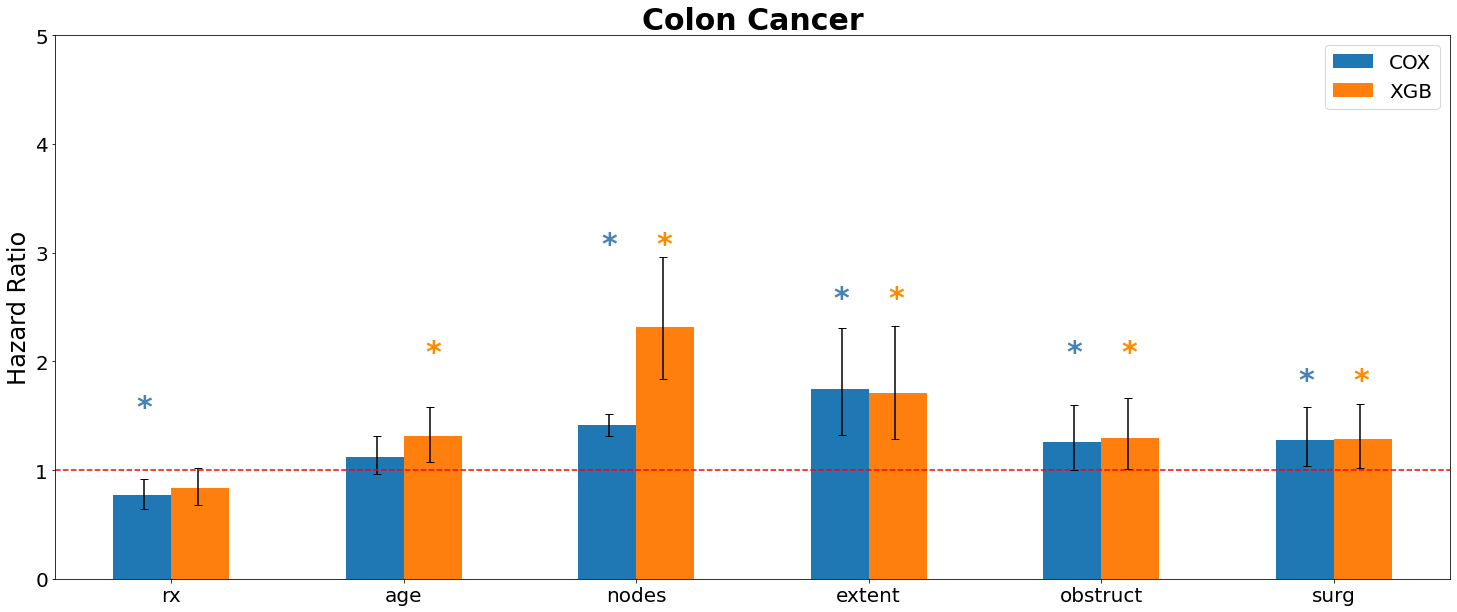

In [24]:
#append lists
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
errorsDictSig = {}
totalCoxList =  HRs_cont_all + list_HRs_all  
mySummaries_reor = mySummaries[:1] + mySummaries[2:3] + mySummaries[6:9] + mySummaries[1:2] + mySummaries[3:6] + mySummaries[9:]
#get the union of all sig covs
all_sig_covs = [origCols[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_sig_covs = [mySummaries_reor[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]

cox_sig_covs = [totalCoxList[i] for i in range(len(origCols)) 
                    if ((totalCoxList[i][1] > 1 and totalCoxList[i][2]) > 1 
                        or (totalCoxList[i][1] < 1 and totalCoxList[i][2] < 1)
                       or (mySummaries_reor[i][1] > 1 and mySummaries_reor[i][2] > 1) 
                        or (mySummaries_reor[i][1] < 1 and mySummaries_reor[i][2] < 1))]


#rename (if needed)


df_cox_sig_all = pd.DataFrame(cox_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxSig = np.array([list(df_cox_sig_all.medianHR - df_cox_sig_all.LB_HR),list(df_cox_sig_all.UB_HR - df_cox_sig_all.medianHR)])
errorsDictSig["COX"] = errorsCoxSig

df_xgb_sig_all = pd.DataFrame(xgb_sig_covs, index = all_sig_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_sig_all.medianHR - df_xgb_sig_all.LB_HR),list(df_xgb_sig_all.UB_HR - df_xgb_sig_all.medianHR)])
errorsDictSig["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_sig_all = pd.DataFrame({"COX":list(df_cox_sig_all.medianHR), 
                          "XGB":list(df_xgb_sig_all.medianHR)},
                         index = all_sig_covs)

cats = all_sig_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax_sig = total_plot_sig_all.plot.bar(rot=0)
ax_sig.set_title("Colon Cancer", fontsize = 30, weight = "heavy")
ax_sig.axhline(y=1 , color='r', linestyle='--')
ax_sig.set_ylabel("Hazard Ratio", fontsize = 24)
ax_sig.set_ylim((0, 5))
for label in (ax_sig.get_xticklabels() + ax_sig.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_sig_all.medianHR, yerr = errorsDictSig["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_sig_all.medianHR, yerr = errorsDictSig["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)


plt.text(0-.15, 1.5, "*", fontsize= 30,weight="heavy", color = "SteelBlue")
# plt.text(0+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(1+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(2-.15, 3, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(2+.085, 3, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(3-.15, 2.5, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(3+.085, 2.5, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(4-.15, 2, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(4+.085, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
plt.text(5-.15, 1.75, "*", fontsize= 30, weight="heavy", color = "SteelBlue")
plt.text(5+.085, 1.75, "*", fontsize= 30, weight="heavy", color = "DarkOrange")


plt.savefig(save_to + 'ccd_sigonly_allcov_XGB_COX.png', bbox_inches = "tight", dpi = 400)

In [19]:
df_xgb_sig_all

,medianHR,LB_HR,UB_HR
rx,0.836782,0.676304,1.022301
age,1.310075,1.074473,1.583737
nodes,2.316882,1.837945,2.962797
extent,1.713371,1.286206,2.324069
obstruct,1.299072,1.009417,1.661859
surg,1.287075,1.023599,1.603500


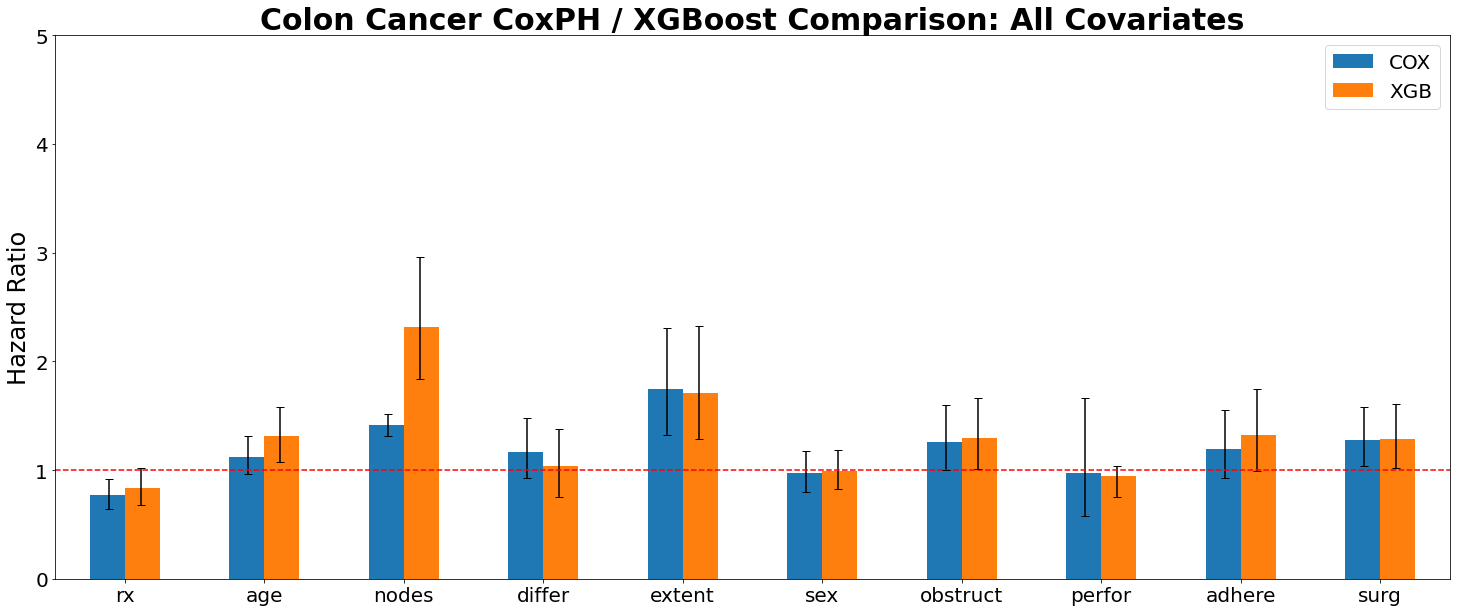

In [26]:
#append lists
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 10]
errorsDictAll = {}
# totalCoxList =  HRs_cont_all + list_HRs_all  
# mySummaries_reor = mySummaries[:1] + mySummaries[2:3] + mySummaries[6:9] + mySummaries[1:2] + mySummaries[3:6] + mySummaries[9:]
#get the union of all sig covs
all_covs = [origCols[i] for i in range(len(origCols))]

# all_sig_covs_names = [tup[0] for tup in all_sig_covs]
# all_sig_covs_numInd = [tup[1] for tup in all_sig_covs]
xgb_all_covs = [mySummaries_reor[i] for i in range(len(origCols))]

cox_all_covs = [totalCoxList[i] for i in range(len(origCols))]

#rename (if needed)


df_cox_all = pd.DataFrame(cox_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
# print(df_cox_conts_all)
errorsCoxAll = np.array([list(df_cox_all.medianHR - df_cox_all.LB_HR),list(df_cox_all.UB_HR - df_cox_all.medianHR)])
errorsDictAll["COX"] = errorsCoxAll

df_xgb_all = pd.DataFrame(xgb_all_covs, index = all_covs, columns = ["medianHR", "LB_HR", "UB_HR"])
errorsXGBSig = np.array([list(df_xgb_all.medianHR - df_xgb_all.LB_HR),list(df_xgb_all.UB_HR - df_xgb_all.medianHR)])
errorsDictAll["XGB"] = errorsXGBSig

#All Sig Variables
total_plot_all = pd.DataFrame({"COX":list(df_cox_all.medianHR), 
                          "XGB":list(df_xgb_all.medianHR)},
                         index = all_covs)

cats = all_covs
x1 = np.arange(len(cats)) + 0.115 #offset 
x2 = np.arange(len(cats)) - 0.115 #offset
ax = total_plot_all.plot.bar(rot=0)
ax.set_title("Colon Cancer CoxPH / XGBoost Comparison: All Covariates", fontsize = 30, weight = "heavy")
ax.axhline(y=1 , color='r', linestyle='--')
ax.set_ylabel("Hazard Ratio", fontsize = 24)
ax.set_ylim((0, 5))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.legend(loc = 1,fontsize = 20)
plt.errorbar(x1, df_xgb_all.medianHR, yerr = errorsDictAll["XGB"], ecolor = 'black', linestyle = 'None', capsize = 4)
plt.errorbar(x2, df_cox_all.medianHR, yerr = errorsDictAll["COX"], ecolor = 'black', linestyle = 'None', capsize = 4)


# plt.text(0-.15, 1.5, "*", fontsize= 30,weight="heavy", color = "Navy")
# # plt.text(0+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(1+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(2-.15, 2.75, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(2+.092, 2.75, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(3-.15, 2.5, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(3+.092, 2.5, "*", fontsize= 30, weight="heavy", color = "DarkOrange")
# plt.text(4-.15, 2, "*", fontsize= 30, weight="heavy", color = "Navy")
# plt.text(4+.092, 2, "*", fontsize= 30, weight="heavy", color = "DarkOrange")

plt.savefig(save_to + 'ccd_allcov_XGB_COX.png')

## C-Index comparison

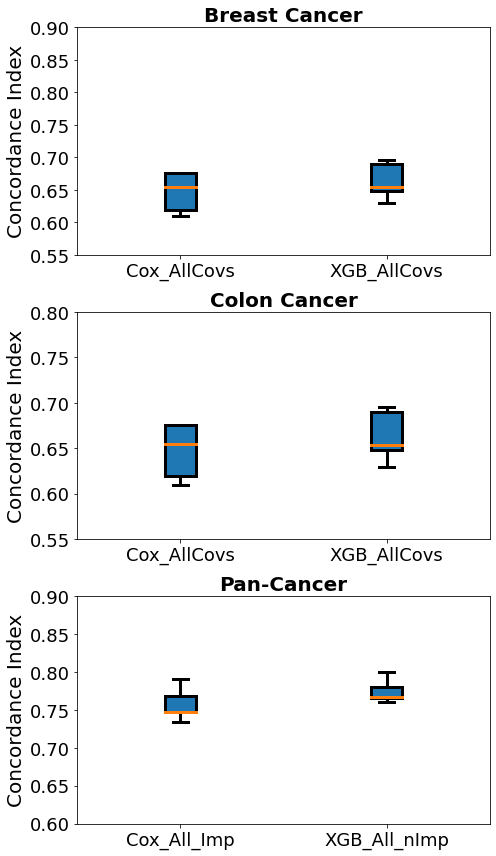

In [151]:
#From 5-Fold CV in R (see R notebook)
coxPH_cindices = [0.6098947, 0.6751284, 0.6756624, 0.6192138, 0.6549967]
xgb_cindices = [0.6955977988994497,
 0.6293322628127928,
 0.6540423361387401,
 0.6898670679709055,
 0.6479621290844013]

box_data = [coxPH_cindices, xgb_cindices]
# print(box_data)
fig = plt.figure(figsize =(7, 12)) 
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.01)
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'20', 'color':'black', 'weight':'heavy'} # Bottom vertical alignment for more space
axis_font = {'size':'20'}
# Creating axes instance 

coxCs = [0.7331452, 0.715131, 0.7260905, 0.7266426, 0.782861]
xgbCs = [0.7839305103148752,
 0.6783340717766947,
 0.7650669642857143,
 0.7093124456048738,
 0.8002033553634977]

Cox_all = [0.7466364, 0.7911606, 0.7679637, 0.7341046, 0.7471551]
xgb_score_nImp = [0.7800129785853342,
 0.7998829154063811,
 0.766468867073204,
 0.7653107107527204,
 0.7605326687952652]

box_data_pan = [Cox_all, xgb_score_nImp]

box_data2 = [coxCs, xgbCs]
# print(box_data)
# fig = plt.figure(figsize =(10, 7)) 
  
# Set the font dictionaries (for plot title and axis titles)
title_font = {'size':'20', 'color':'black', 'weight':'heavy'} # Bottom vertical alignment for more space
axis_font = {'size':'20'}
# Creating axes instance 
ax2 = fig.add_subplot(311) 
ax2.set_xticklabels(['Cox_AllCovs', 'XGB_AllCovs'])
ax2.set_title("Breast Cancer", **title_font)
ax2.set_ylabel("Concordance Index", **axis_font)
ax2.set_ylim(0.55, 0.90)

for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp2 = ax2.boxplot(box_data, patch_artist=True) 

for median in bp2['medians']:
    median.set(linewidth=3)

for box in bp2['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp2['whiskers']:
    whisker.set(linewidth =3)

for cap in bp2['caps']:
    cap.set(linewidth=3)

ax = fig.add_subplot(312)
ax.set_xticklabels(['Cox_AllCovs', 'XGB_AllCovs'])
ax.set_title("Colon Cancer", **title_font)
ax.set_ylabel("Concordance Index", **axis_font)
ax.set_ylim(0.55, 0.80)



# for item in [ax.title]:
#     item.set_fontsize(20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp = ax.boxplot(box_data, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)

ax3 = fig.add_subplot(313)
ax3.set_xticklabels(['Cox_All_Imp', 'XGB_All_nImp'])
ax3.set_title("Pan-Cancer", **title_font)
ax3.set_ylabel("Concordance Index", **axis_font)
ax3.set_ylim(0.6, 0.90)



# for item in [ax.title]:
#     item.set_fontsize(20)
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontsize(18)

# Creating plot 
bp = ax3.boxplot(box_data_pan, patch_artist=True) 

for median in bp['medians']:
    median.set(linewidth=3)

for box in bp['boxes']:
# change outline color
    box.set(linewidth=3)

for whisker in bp['whiskers']:
    whisker.set(linewidth =3)

for cap in bp['caps']:
    cap.set(linewidth=3)


# show plot
plt.tight_layout()
plt.show()
fig.savefig(save_to + 'ccd_bcd_pan_box_plot_cindex.png',  bbox_inches = "tight", dpi = 400)

In [130]:
%matplotlib inline

## SHAP Exploration 

In [131]:
#Model trained, using for SHAP analysis
X_train = full_xy.sample(n = full_xy.shape[0], random_state = i, replace = True) #sample w/ replacement num rows
y_train = X_train['y'] #y train are X_trains y column
X_train = X_train.drop(columns = ['y']) #X_train then needs to drop the y column
X_test = full_xy.drop(X_train.index) #test features are the full - X_train
y_test = X_test['y'] #y test are X_tests y column
X_test = X_test.drop(columns = ['y']) #X_test then needs to drop they column
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)
model_train_SHAP = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=False)
    
#   let's get the SHAP vals and a HR from these based on our model
shap_values= shap.TreeExplainer(model_train_SHAP).shap_values(X_ccd)

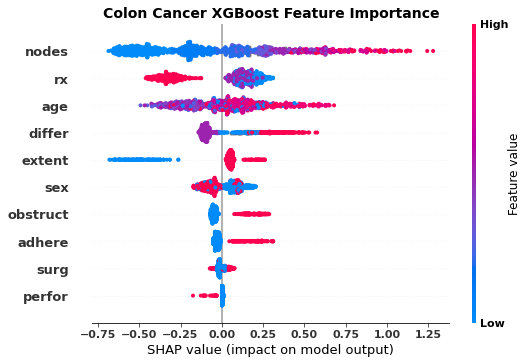

In [132]:
shap.summary_plot(shap_values, X_ccd, show = False)
plt.title("Colon Cancer XGBoost Feature Importance", fontsize = 14, weight = 'bold')
plt.savefig(save_to + "importance_plot_all_XGBoost_CCD.png",  bbox_inches = "tight", dpi = 400) 

[15:04:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { axes.labelsize, axes.titlesize, figure.figsize, fontsize, legend.fontsize, xtick.labelsize, ytick.labelsize } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:1736.69800
[250]	test-rmse:2014.87598
[500]	test-rmse:2041.10242
[750]	test-rmse:2044.31519
[999]	test-rmse:2044.95056


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


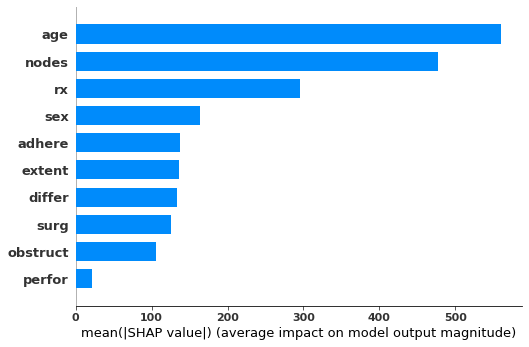

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


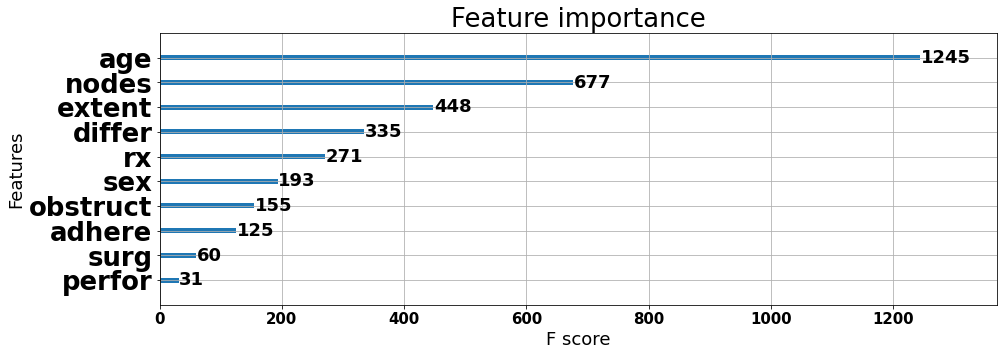

In [120]:
xgb_model_test = xgboost.train(params, xgb_train, 1000,
                          evals=[(xgb_test, "test")],
                          verbose_eval=250)
# predictions = xgb_model_test.predict(X_ccd)
# print(c_statistic_harrell(predictions, list(y_ccd)))

shap.summary_plot(shap_values, X_ccd, plot_type="bar")
xgboost.plot_importance(model_train)
# shap_EXTENT =shap_values_full[:,idx_extent]
# print(X_ccd["differ"].unique())
# np.exp(int(shap_EXTENT[X_ccd["extent"]) >= 1])/np.median(np.exp(int(shap_EXTENT[X_ccd["extent"])==0])

In [113]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)  # pass in the font dict as kwargs

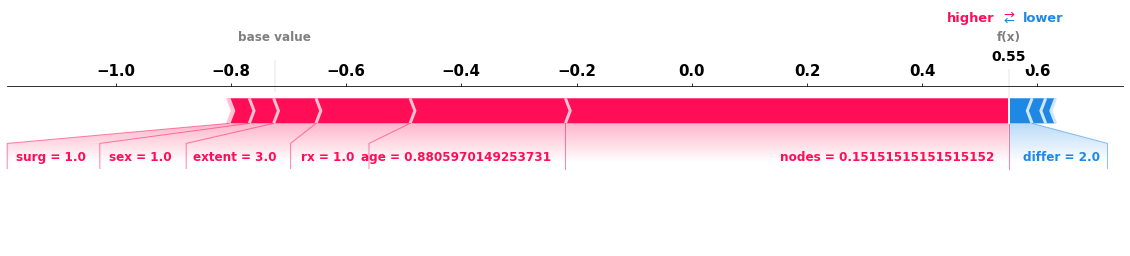

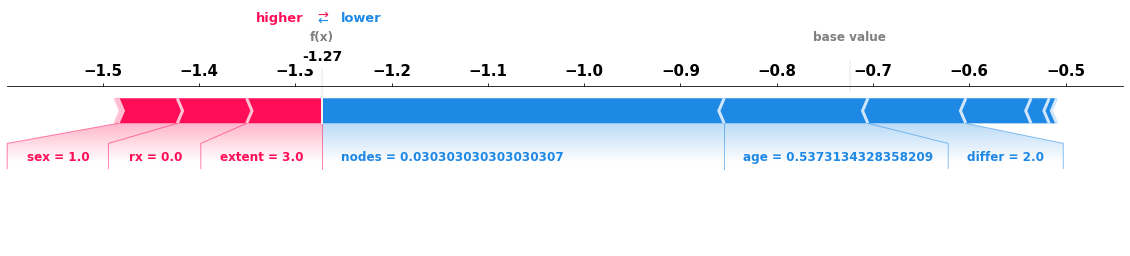

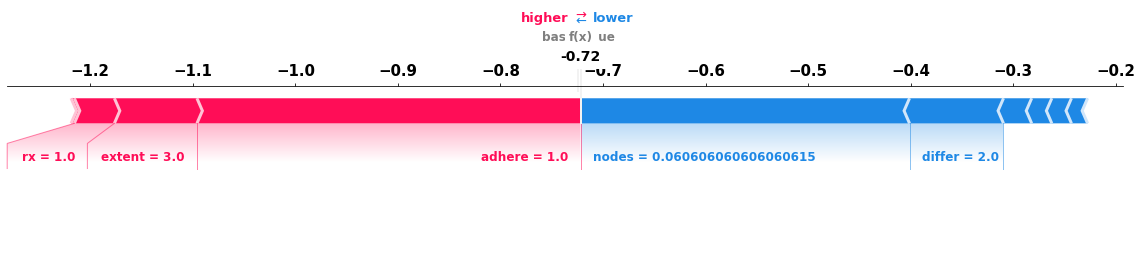

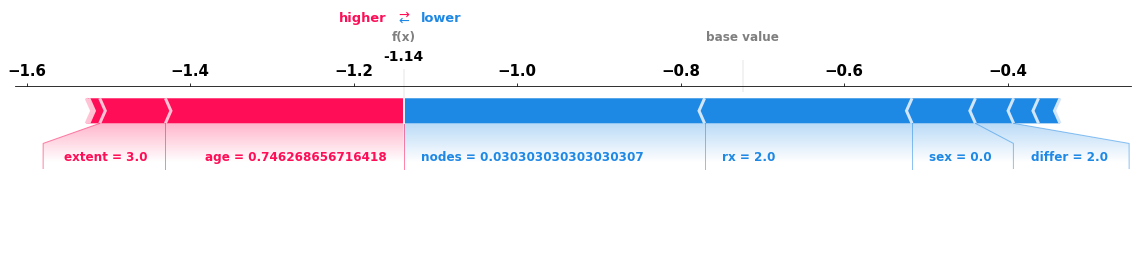

In [116]:
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_ccd)

# visualize the first three prediction's explanation (use matplotlib=True to avoid Javascript)
for i in range(6, 10):
    shap.force_plot(explainer.expected_value, shap_values[i,:],
                X_ccd.iloc[i,:],show=False,matplotlib=True).savefig(save_to + 'force_plot_p' + str(i + 1) + '.png', 
                                                                    bbox_inches = "tight", dpi = 400)

In [90]:
np.round(shap_values, decimals=4)

array([[-0.0696, -0.0414, -0.1407, ..., -0.1438,  0.0554, -0.0209],
       [-0.2598,  0.0583, -0.3053, ..., -0.0723,  0.0718, -0.0022],
       [ 0.0655,  0.0035,  0.1774, ..., -0.0159, -0.5484,  0.0126],
       ...,
       [ 0.1608,  0.1041,  0.0798, ...,  0.1285,  0.0986, -0.0031],
       [-0.0747, -0.0177, -0.2536, ..., -0.0902,  0.0386,  0.0713],
       [ 0.1636, -0.0992,  0.2354, ..., -0.046 ,  0.0535, -0.0069]],
      dtype=float32)

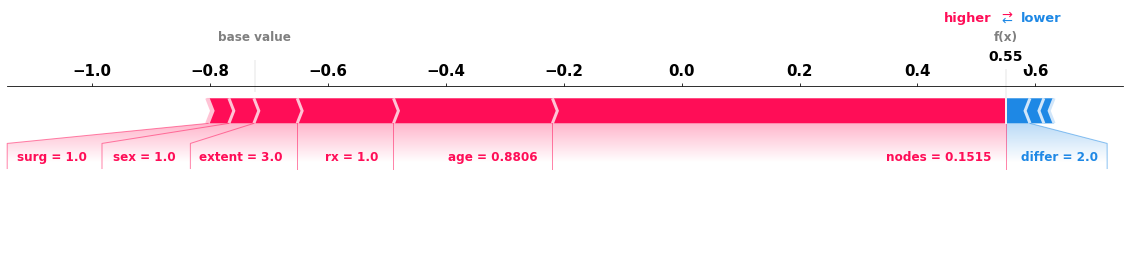

In [115]:
ax = shap.force_plot(explainer.expected_value, np.round(shap_values[6,:],decimals=4),
                np.round(X_ccd.iloc[6,:], decimals=4),show=False,matplotlib=True)
# plt.title("SHAP Force Plot Demo", fontsize = 16, weight = 'bold')
plt.savefig(save_to + "force_demo.png",  bbox_inches = "tight", dpi = 400)
plt.show()

In [57]:
shap.force_plot(explainer.expected_value, shap_values, X_ccd)

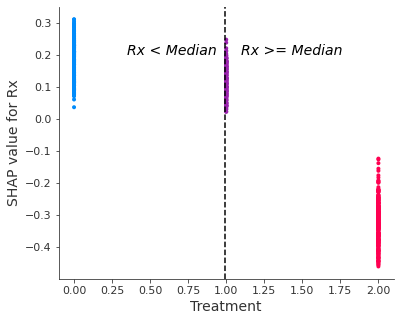

In [55]:
shap.dependence_plot("rx", shap_values, X_ccd, interaction_index="rx", show = False)
# plt.title("SHAP Dependence Plot", fontsize = 14, weight = 'bold')
plt.ylabel("SHAP value for Rx", fontsize = 14)
plt.xlabel("Treatment", fontsize = 14)
plt.axvline(x= np.median(X_ccd['rx'] - .005) , color='black', linestyle='--')
plt.text(1.1, 0.2, "Rx >= Median", style='italic', fontsize = 14)
plt.text(0.35, 0.2, "Rx < Median", style='italic', fontsize = 14)
plt.savefig(save_to + "dependence_plot_rx.png",  bbox_inches = "tight", dpi = 400) 
plt.show()

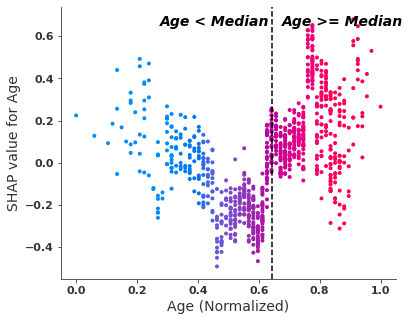

In [135]:
shap.dependence_plot("rank(2)", shap_values, X_ccd, interaction_index = "rank(2)", show = False)
# plt.title("SHAP Dependence Plot", fontsize = 14, weight = 'bold')
plt.ylabel("SHAP value for Age", fontsize = 14)
plt.xlabel("Age (Normalized)", fontsize = 14)
plt.axvline(x= np.median(X_ccd['age']) , color='black', linestyle='--')
plt.text(0.275, 0.65, "Age < Median", style='italic', fontsize = 14)
plt.text(0.675, 0.65, "Age >= Median", style='italic', fontsize = 14)
plt.savefig(save_to + "dependence_plot_age.png",  bbox_inches = "tight", dpi = 400) 
plt.show()